In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import os
import sys
import pickle
import json
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from scipy.sparse.linalg import lsqr
from copy import deepcopy
from sklearn.decomposition import PCA
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import *
from src.PerformanceAnalyzer import *
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.PerformanceAnalyzer import PerformanceAnalyzerCDDM

In [2]:
RNN_folder = "0.0067646_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000"
LC_folder = "0.0067646_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000"
print(RNN_folder)
RNN_score = float(RNN_folder.split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", "CDDM", RNN_folder)
LC_folder_path = os.path.join('../', "data", "inferred_LCs", LC_folder)
mse_score_RNN = RNN_folder.split("_")[0]

0.0067646_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000


In [3]:
subfolders = os.listdir(LC_folder_path)
ind = 0
max_score = -10
for i, subfolder in enumerate(subfolders):
    if "8nodes" in subfolder or '8-nodes' in subfolder:
        score = float(subfolder.split("_")[0])
        if max_score <= score:
            max_score = score
            ind = i 
LC_subfolder = subfolders[ind]
LC_path = os.path.join('../', "data", "inferred_LCs", LC_folder, LC_subfolder)

rnn_config = json.load(open(os.path.join(RNN_path, f"{mse_score_RNN}_config.json"), "rb+"))
rnn_data = json.load(open(os.path.join(RNN_path, f"{mse_score_RNN}_params_CDDM.json"), "rb+"))
train_config_file = f"train_config_CDDM_relu.json"

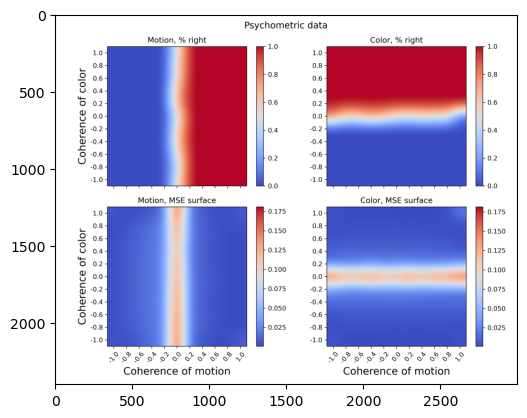

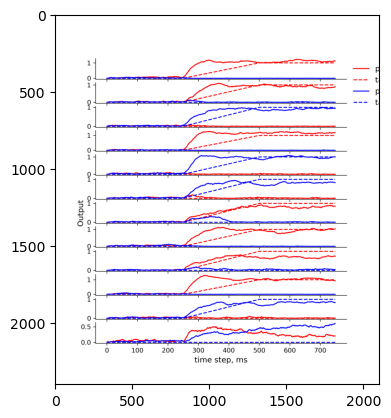

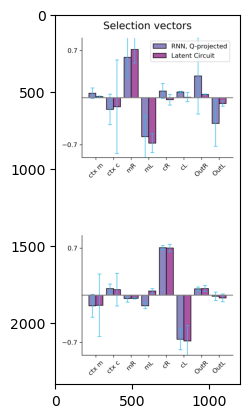

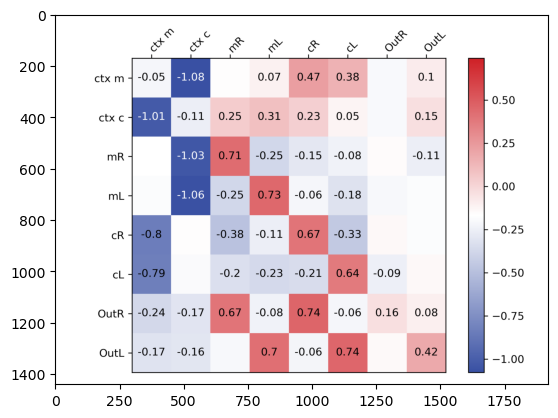

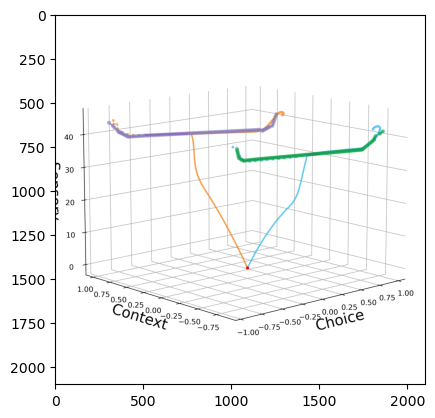

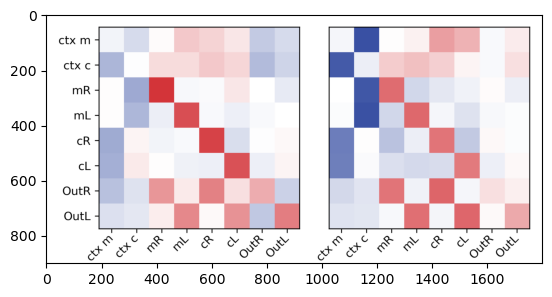

In [4]:
img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_psychometric.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_random_trials.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_selection_vects_comparison.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_wrec.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_LA3D.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_wrec_comparison.png"), 'rb+'))
plt.imshow(img)
plt.show()

In [5]:
activation_name = rnn_config["activation"]
RNN_N = rnn_config["N"]
n_steps = rnn_config["n_steps"]
task_params = rnn_config["task_params"]
if activation_name == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation_RNN = torch.tanh
elif activation_name == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))
dt = rnn_config["dt"]
tau = rnn_config["tau"]
connectivity_density_rec = rnn_config["connectivity_density_rec"]
spectral_rad = rnn_config["sr"]
sigma_inp = rnn_config["sigma_inp"]
sigma_rec = rnn_config["sigma_rec"]
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)
input_size = np.array(rnn_data["W_inp"]).shape[1]
output_size = np.array(rnn_data["W_out"]).shape[0]
mask = np.array(rnn_config["mask"])
RNN = RNN_torch(N=RNN_N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation_RNN, random_generator=rng, device=device,
                      sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": np.array(rnn_data["W_inp"]),
              "W_rec": np.array(rnn_data["W_rec"]),
              "W_out": np.array(rnn_data["W_out"]),
              "b_rec": np.array(rnn_data["bias_rec"]),
              "y_init": np.zeros(RNN_N)}
RNN.set_params(RNN_params)
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)

seed: 598767
Using cpu for RNN!


In [6]:
# validate
coherences_valid = np.linspace(-1, 1, 11)
task_params_valid = deepcopy(task_params)
task_params_valid["coherences"] = coherences_valid
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params_valid)

if activation_name == 'relu':
    activation_np = lambda x : np.maximum(0.0, x)
elif activation_name == 'tanh':
    activation_np = lambda x : np.tanh(x)
RNN_valid_control = RNN_numpy(N=RNN_N,
                      dt=rnn_data["dt"],
                      tau=rnn_data["tau"],
                      activation = activation_np,
                      W_inp=np.array(rnn_data["W_inp"]),
                      W_rec=np.array(rnn_data["W_rec"]),
                      W_out=np.array(rnn_data["W_out"]),
                      bias_rec=None,
                      y_init=np.zeros(RNN_N))


analyzer = PerformanceAnalyzerCDDM(RNN_valid_control)
score_function = lambda x, y: np.mean((x - y) ** 2)
Task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)

input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid, mask, sigma_rec=0, sigma_inp=0.)
score = np.round(score, 7)
print(score)

0.0067646


In [7]:
try:
    LC_data = json.load(open(os.path.join(LC_path, f"{max_score}_LC_params.json"), "rb+"))
except:
    LC_data = pickle.load(open(os.path.join(LC_path, f"{max_score}_LC_params.pkl"), "rb+"))
U = np.array(LC_data["U"])
q = np.array(LC_data["q"])
try:
    Q = U.T @ q
except:
    Q = (q @ U).T
w_out = np.array(LC_data["W_out"])
w_rec = np.array(LC_data["W_rec"])
w_inp = np.array(LC_data["W_inp"])
n = LC_data["n"]
N = LC_data["N"]
dt = LC_data["dt"]
tau = LC_data["tau"]

In [8]:
dsa0 = DynamicSystemAnalyzerCDDM(RNN_valid_control)
params = {"fun_tol": 0.05,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 5,
          "patience": 50,
          "stop_length": 50,
          "mode": "approx"}

dsa0.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
dsa0.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)
print(f"Calculating Line Attractor analytics")
dsa0.calc_LineAttractor_analytics()

Calculating Line Attractor analytics
Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

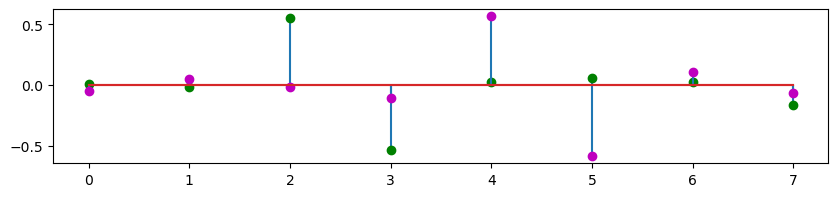

In [9]:
s0_norms_motion = np.linalg.norm(dsa0.LA_data["motion"]["l"], axis = 1)
s0_motion = dsa0.LA_data["motion"]["l"] / np.hstack([s0_norms_motion.reshape(-1, 1)] * RNN_N)
s0_motion = np.mean(s0_motion @ Q, axis = 0)

s0_norms_color = np.linalg.norm(dsa0.LA_data["color"]["l"], axis = 1)
s0_color = dsa0.LA_data["color"]["l"] / np.hstack([s0_norms_color.reshape(-1, 1)] * RNN_N)
s0_color = np.mean(s0_color @ Q, axis = 0)

fig = plt.figure(figsize = (10,2))
plt.stem(s0_motion, markerfmt='g')
plt.stem(s0_color, markerfmt='m')
plt.show()

In [10]:
# now! design a perturbation to the weights of the RNN!

In [11]:
delta_w = np.zeros((8, 8))
delta_w[2, 1] = 1
delta_w[3, 1] = 1
delta_W = 0.5 * Q @ delta_w @ Q.T #add more excitation
W_rec_corupted = np.array(rnn_data["W_rec"]) + delta_W

In [12]:
np.round(Q.T @ W_rec_corupted @ Q, 3)

array([[-0.072, -0.222,  0.022,  0.262,  0.216,  0.122, -0.325, -0.225],
       [-0.45 , -0.01 ,  0.171,  0.171,  0.269,  0.199, -0.416, -0.269],
       [ 0.013, -0.024,  0.979, -0.044, -0.031,  0.123, -0.003, -0.13 ],
       [ 0.013,  0.062, -0.103,  0.856, -0.035, -0.096, -0.034, -0.007],
       [-0.516,  0.055, -0.07 , -0.034,  0.912, -0.206, -0.013,  0.042],
       [-0.495,  0.109,  0.009, -0.091, -0.097,  0.841, -0.098,  0.056],
       [-0.38 , -0.182,  0.505,  0.109,  0.613,  0.156,  0.399, -0.279],
       [-0.189, -0.148,  0.093,  0.581,  0.03 ,  0.53 , -0.339,  0.631]])

In [13]:
# validate
coherences_valid = np.linspace(-1, 1, 11)
task_params_valid = deepcopy(task_params)
task_params_valid["coherences"] = coherences_valid
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params_valid)

if activation_name == 'relu':
    activation_np = lambda x : np.maximum(0.0, x)
elif activation_name == 'tanh':
    activation_np = lambda x : np.tanh(x)
RNN_valid_corrupted = RNN_numpy(N=RNN_N,
                      dt=rnn_data["dt"],
                      tau=rnn_data["tau"],
                      activation = activation_np,
                      W_inp=np.array(rnn_data["W_inp"]),
                      W_rec=W_rec_corupted,
                      W_out=np.array(rnn_data["W_out"]),
                      bias_rec=None,
                      y_init=np.zeros(RNN_N))


analyzer = PerformanceAnalyzerCDDM(RNN_valid_corrupted)
score_function = lambda x, y: np.mean((x - y) ** 2)
Task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)

input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
size = input_batch_valid.shape[-1]
input_batch_valid = input_batch_valid[..., size//2:]
target_batch_valid = target_batch_valid[..., size//2:]
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid, mask, sigma_rec=0, sigma_inp=0.)
score = np.round(score, 7)
print(score)

0.0312813


Plotting psychometric data


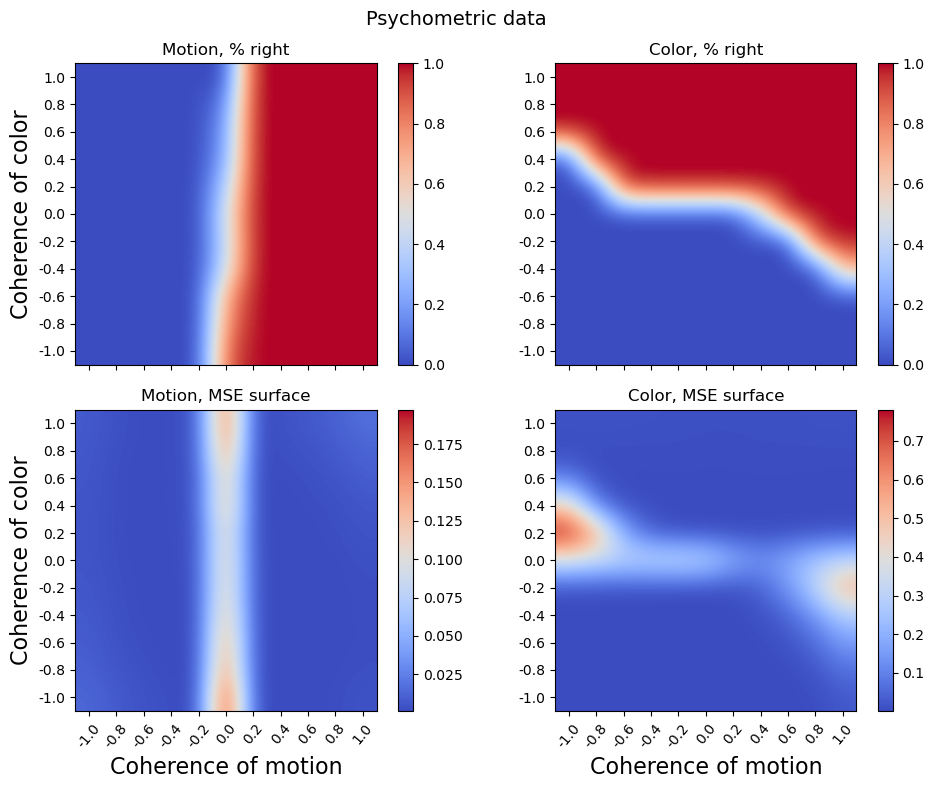

Plotting random trials


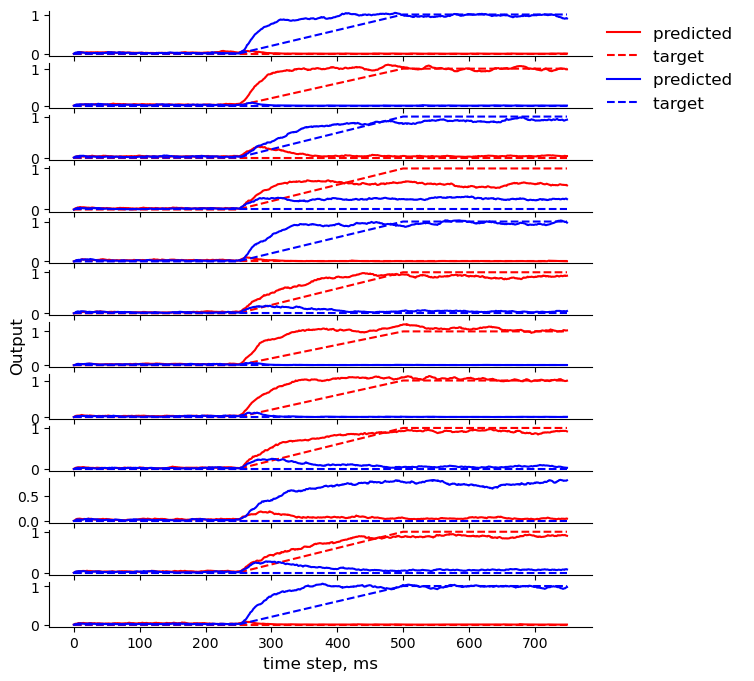

In [14]:
print(f"Plotting psychometric data")
num_levels = len(coherences_valid)
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()

print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]

fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=0.03, sigma_inp=0.03)
plt.show()

Calculating Line Attractor analytics
Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

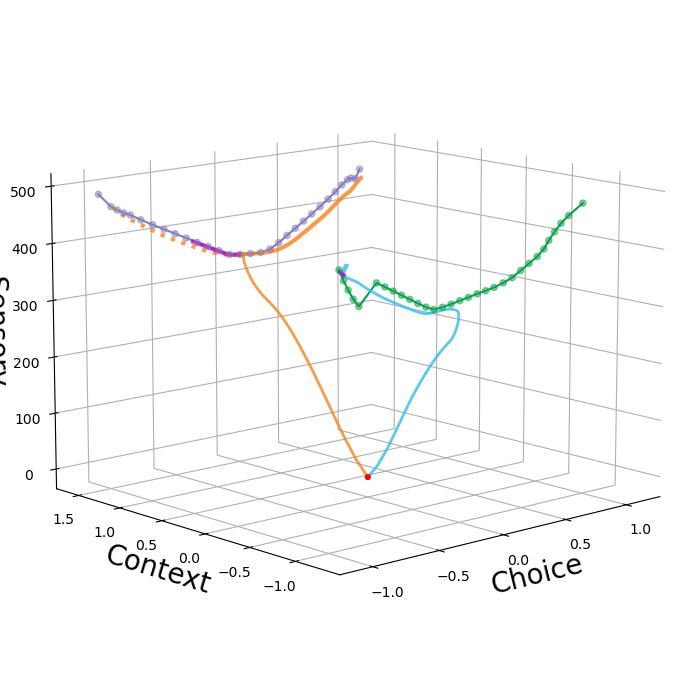

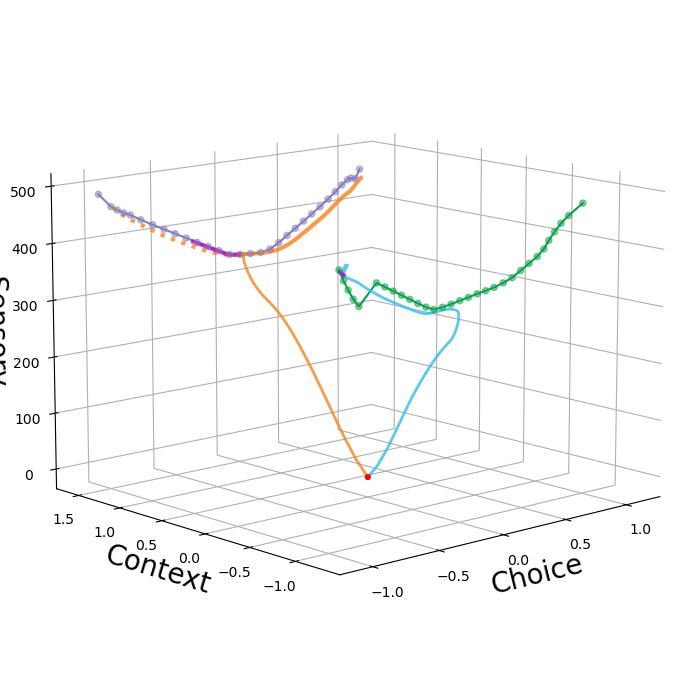

In [15]:
dsa1 = DynamicSystemAnalyzerCDDM(RNN_valid_corrupted)
params = {"fun_tol": 0.05,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 5,
          "patience": 50,
          "stop_length": 50,
          "mode": "approx"}

dsa1.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
dsa1.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)
print(f"Calculating Line Attractor analytics")
dsa1.calc_LineAttractor_analytics()
dsa1.plot_LineAttractor_3D()

In [16]:
len(np.linalg.norm(dsa1.LA_data["motion"]["l"], axis = 1))

31

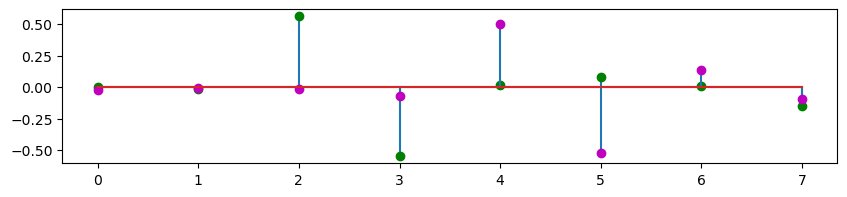

In [17]:
s1_norms_motion = np.linalg.norm(dsa1.LA_data["motion"]["l"], axis = 1)
s1_motion = dsa1.LA_data["motion"]["l"] / np.hstack([s1_norms_motion.reshape(-1, 1)] * RNN_N)
s1_motion = np.mean(s1_motion @ Q, axis = 0)

s1_norms_color = np.linalg.norm(dsa1.LA_data["color"]["l"], axis = 1)
s1_color = dsa1.LA_data["color"]["l"] / np.hstack([s1_norms_color.reshape(-1, 1)] * RNN_N)
s1_color = np.mean(s1_color @ Q, axis = 0)

fig = plt.figure(figsize = (10,2))
plt.stem(s1_motion, markerfmt='g')
plt.stem(s1_color, markerfmt='m')
plt.show()

In [18]:
delta_w = np.zeros((8, 8))
delta_w[2, 1] = 1
delta_w[3, 1] = 1
delta_W = -0.5 * Q @ delta_w @ Q.T #add more inhibition
W_rec_enhanced = np.array(rnn_data["W_rec"]) + delta_W

In [19]:
np.round(Q.T @ W_rec_enhanced @ Q, 3) - delta_w

array([[-0.072, -0.222,  0.022,  0.262,  0.216,  0.122, -0.325, -0.225],
       [-0.45 , -0.01 ,  0.171,  0.171,  0.269,  0.199, -0.416, -0.269],
       [ 0.013, -2.025,  0.979, -0.044, -0.031,  0.123, -0.003, -0.13 ],
       [ 0.013, -1.938, -0.103,  0.856, -0.035, -0.096, -0.034, -0.007],
       [-0.516,  0.055, -0.07 , -0.034,  0.912, -0.206, -0.013,  0.042],
       [-0.495,  0.109,  0.009, -0.091, -0.097,  0.841, -0.098,  0.056],
       [-0.38 , -0.182,  0.505,  0.109,  0.613,  0.156,  0.399, -0.279],
       [-0.189, -0.148,  0.093,  0.581,  0.03 ,  0.53 , -0.339,  0.631]])

In [20]:
# validate
coherences_valid = np.linspace(-1, 1, 11)
task_params_valid = deepcopy(task_params)
task_params_valid["coherences"] = coherences_valid
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params_valid)

activation_np = lambda x : np.maximum(0.0, x)
RNN_valid_enhanced = RNN_numpy(N=RNN_N,
                      dt=rnn_data["dt"],
                      tau=rnn_data["tau"],
                      activation = activation_np,
                      W_inp=np.array(rnn_data["W_inp"]),
                      W_rec=W_rec_enhanced,
                      W_out=np.array(rnn_data["W_out"]),
                      bias_rec=None,
                      y_init=np.zeros(RNN_N))


analyzer = PerformanceAnalyzerCDDM(RNN_valid_enhanced)
score_function = lambda x, y: np.mean((x - y) ** 2)
Task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)

input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
size = input_batch_valid.shape[-1]
input_batch_valid = input_batch_valid[..., size//2:]
target_batch_valid = target_batch_valid[..., size//2:]
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid, mask, sigma_rec=0, sigma_inp=0.)
score = np.round(score, 7)
print(score)

0.0188505


Plotting psychometric data


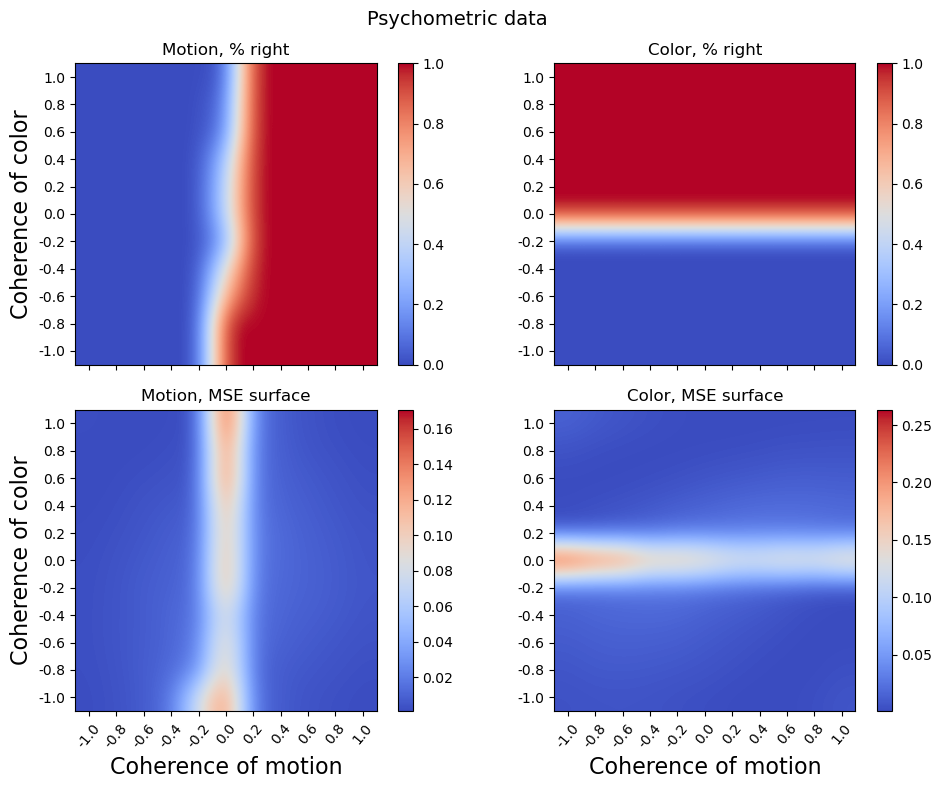

Plotting random trials


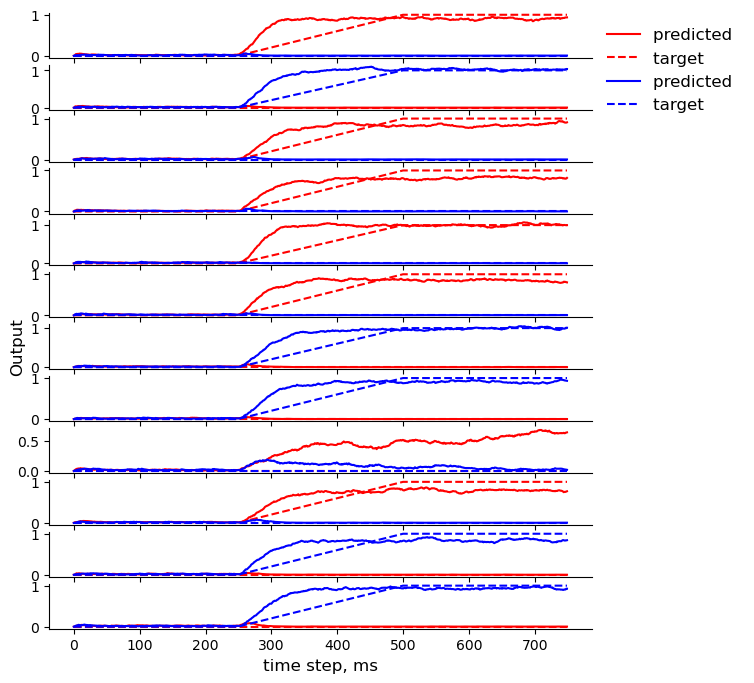

In [21]:
print(f"Plotting psychometric data")
num_levels = len(coherences_valid)
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()

print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]

fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=0.03, sigma_inp=0.03)
plt.show()

In [22]:
dsa2 = DynamicSystemAnalyzerCDDM(RNN_valid_enhanced)
params = {"fun_tol": 0.05,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 5,
          "patience": 50,
          "stop_length": 50,
          "mode": "approx"}

dsa2.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
dsa2.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)
print(f"Calculating Line Attractor analytics")
dsa2.calc_LineAttractor_analytics()

Calculating Line Attractor analytics
Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

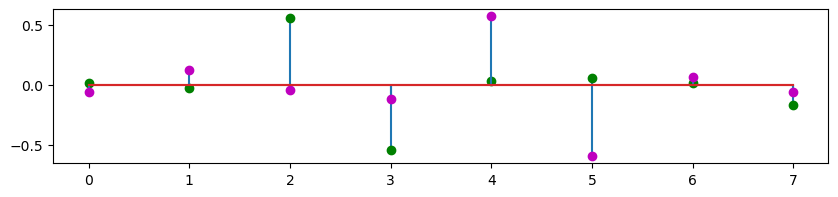

In [23]:
s2_norms_motion = np.linalg.norm(dsa2.LA_data["motion"]["l"], axis = 1)
s2_motion = dsa2.LA_data["motion"]["l"] / np.hstack([s2_norms_motion.reshape(-1, 1)] * RNN_N)
s2_motion = np.mean(s2_motion @ Q, axis = 0)

s2_norms_color = np.linalg.norm(dsa2.LA_data["color"]["l"], axis = 1)
s2_color = dsa2.LA_data["color"]["l"] / np.hstack([s2_norms_color.reshape(-1, 1)] * RNN_N)
s2_color = np.mean(s2_color @ Q, axis = 0)

fig = plt.figure(figsize = (10,2))
plt.stem(s2_motion, markerfmt='g')
plt.stem(s2_color, markerfmt='m')
plt.show()

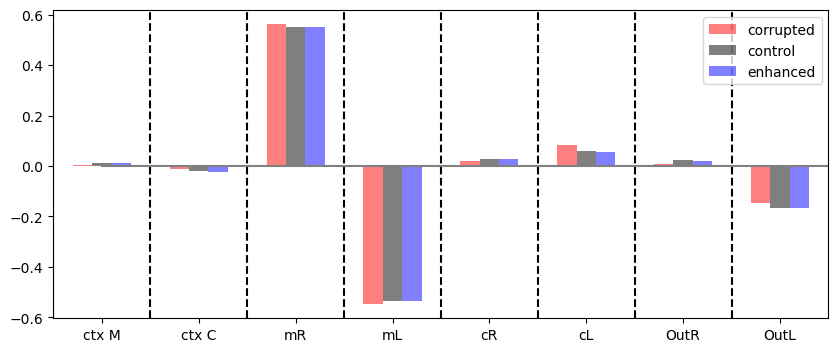

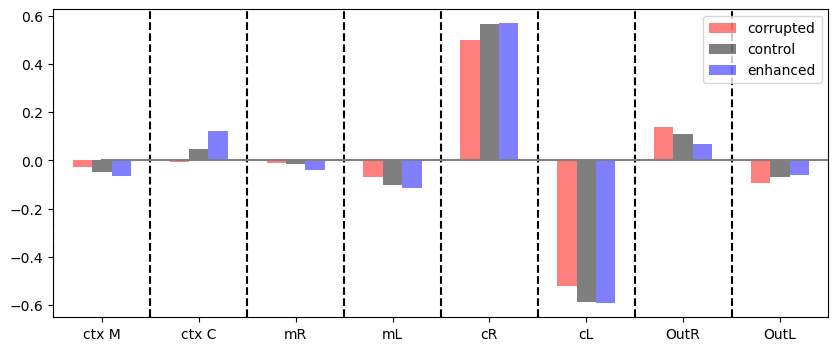

In [24]:
fig = plt.figure(figsize = (10,4))
plt.bar(np.arange(16)[::2]- 0.4, s1_motion, color='r', width = 0.4, alpha = 0.5, label = 'corrupted')
plt.bar(np.arange(16)[::2], s0_motion, color='k', width = 0.4, alpha = 0.5, label='conrol')
plt.bar(np.arange(16)[::2] +0.4, s2_motion, color='b', width = 0.4, alpha = 0.5, label = 'enhanced')
plt.legend(['corrupted', 'control', 'enhanced'])
plt.xticks(ticks = np.arange(16)[::2], labels=["ctx M", "ctx C", "mR", "mL", "cR", "cL", "OutR", "OutL"])
for i in [-1, 1, 3, 5, 7, 9, 11, 13]:
    plt.axvline(i, color = 'k', linestyle='--')
plt.plot([0, 16], [0, 0], color = 'gray')
plt.xlim([-1, 15])
plt.show()

fig = plt.figure(figsize = (10,4))
plt.bar(np.arange(16)[::2]- 0.4, s1_color, color='r', width = 0.4, alpha = 0.5, label = 'corrupted')
plt.bar(np.arange(16)[::2], s0_color, color='k', width = 0.4, alpha = 0.5, label='conrol')
plt.bar(np.arange(16)[::2] +0.4, s2_color, color='b', width = 0.4, alpha = 0.5, label = 'enhanced')
plt.legend(['corrupted', 'control', 'enhanced'])
plt.xticks(ticks = np.arange(16)[::2], labels=["ctx M", "ctx C", "mR", "mL", "cR", "cL", "OutR", "OutL"])
for i in [-1, 1, 3, 5, 7, 9, 11, 13]:
    plt.axvline(i, color = 'k', linestyle='--')
plt.plot([0, 16], [0, 0], color = 'gray')
plt.xlim([-1, 15])
plt.show()